In [50]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPool2D, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Flatten

In [1]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [4]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [7]:
codings = encoder.predict(X_train)

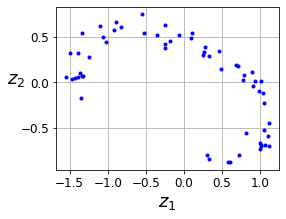

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## Stacked Autoencoders

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9006
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2984 - val_rounded_accuracy: 0.9202
Epoch 4/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(16,8))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

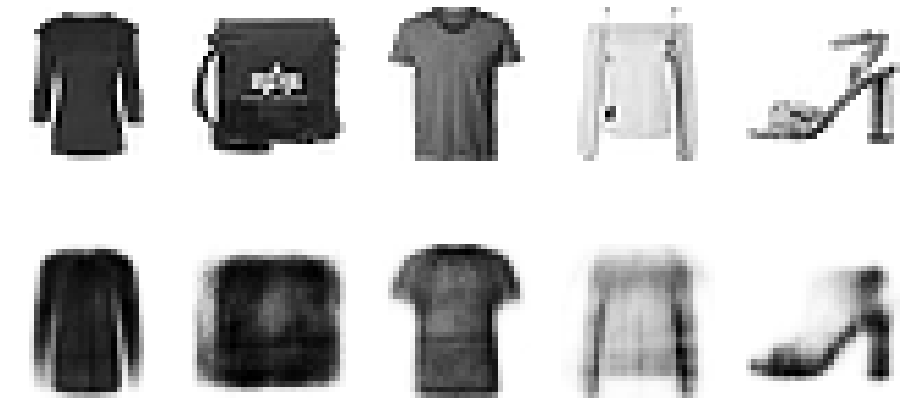

In [13]:
show_reconstructions(stacked_ae)

In [14]:
def show_reconstruction(model, images=X_valid, image_id=1):
    reconstruction = model.predict(tf.expand_dims(images[image_id], axis=0))
    fig = plt.figure(figsize=(16,8))
    plt.subplot(1, 2, 1)
    plot_image(images[image_id])
    plt.subplot(1, 2, 2)
    plot_image(reconstruction[0])

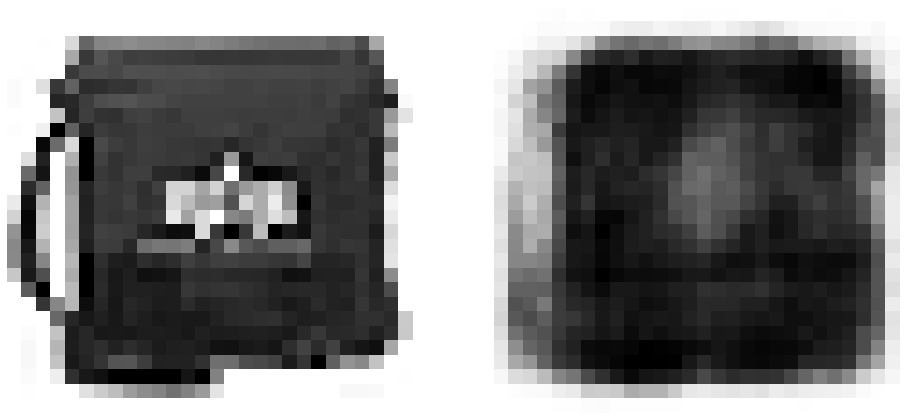

In [15]:
show_reconstruction(stacked_ae)

## Visualizing Fashion MNIST

In [16]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

(-0.05, 1.05, 0.03470206223428249, 0.9351383674889803)

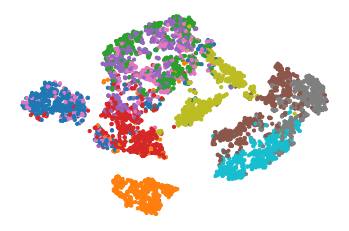

In [17]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")

(-0.05, 1.05, 0.03470206223428249, 0.9351383674889803)

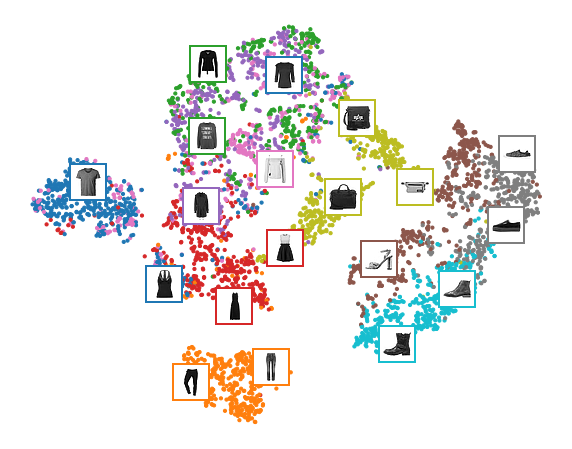

In [18]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")

Do the same autoencoder with tying weights

In [19]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name='bias', initializer='zeros', shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z+self.biases)

In [20]:
dense1 = keras.layers.Dense(100, activation='selu')
dense2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
                                        keras.layers.Flatten(input_shape=[28,28]),
                                        dense1,
                                        dense2
])

tied_decoder = keras.models.Sequential([
                                        DenseTranspose(dense2, activation='selu'),
                                        DenseTranspose(dense1, activation='sigmoid'),
                                        keras.layers.Reshape([28,28])
])

tied_autoencoder = keras.models.Sequential([tied_encoder, tied_decoder])

In [21]:
tied_autoencoder.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=1.5),
    metrics=[rounded_accuracy]
)

history = tied_autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3270 - rounded_accuracy: 0.8959 - val_loss: 0.3068 - val_rounded_accuracy: 0.9095
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2977 - rounded_accuracy: 0.9220 - val_loss: 0.2950 - val_rounded_accuracy: 0.9274
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2918 - rounded_accuracy: 0.9276 - val_loss: 0.2957 - val_rounded_accuracy: 0.9180
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2886 - rounded_accuracy: 0.9305 - val_loss: 0.2880 - val_rounded_accuracy: 0.9322
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9324 - val_loss: 0.2872 - val_rounded_accuracy: 0.9313
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2852 - rounded_accuracy: 0.9336 - val_loss: 0.2862 - val_rounded_accuracy: 0.9341
Epoch 7/20
1719/1719 [==================

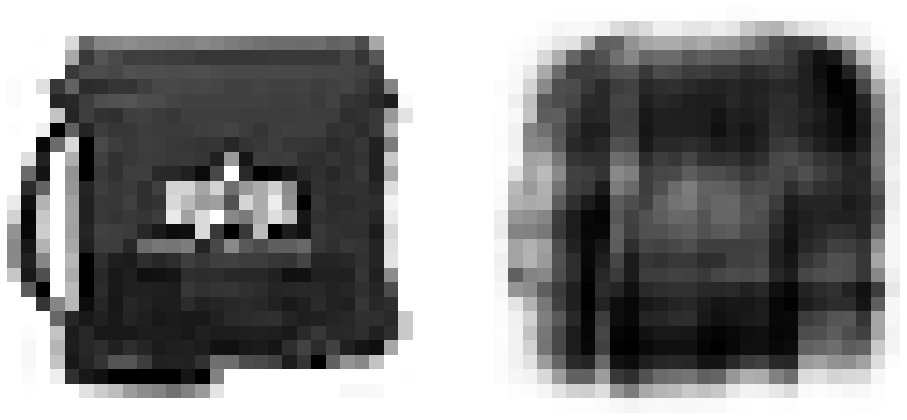

In [22]:
show_reconstruction(tied_autoencoder)

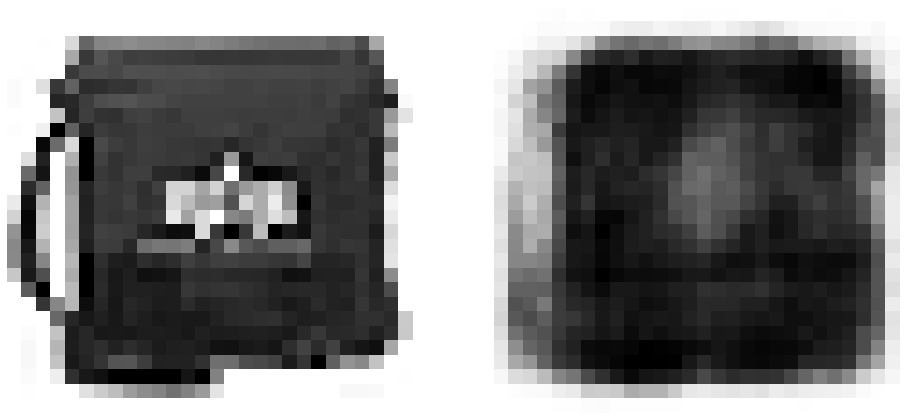

In [23]:
show_reconstruction(stacked_ae)

In [24]:
X_train.shape

(55000, 28, 28)

In [25]:
X_train.shape[-1]

28

## Using Convolutional Layers Instead of Dense Layers

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPool2D, Reshape, Conv2D, Conv2DTranspose

In [27]:
conv_encoder = Sequential([
    Reshape([28,28,1], input_shape=[28,28]),
    Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    MaxPool2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    MaxPool2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    MaxPool2D(pool_size=2),
])

conv_decoder = Sequential([
    Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3,3,64]),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

In [28]:
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3016 - rounded_accuracy: 0.9192 - val_loss: 0.2824 - val_rounded_accuracy: 0.9387
Epoch 2/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2758 - rounded_accuracy: 0.9413 - val_loss: 0.2738 - val_rounded_accuracy: 0.9436
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2709 - rounded_accuracy: 0.9460 - val_loss: 0.2702 - val_rounded_accuracy: 0.9488
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2683 - rounded_accuracy: 0.9488 - val_loss: 0.2687 - val_rounded_accuracy: 0.9489
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2665 - rounded_accuracy: 0.9506 - val_loss: 0.2662 - val_rounded_accuracy: 0.9529


In [29]:
conv_encoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

In [30]:
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


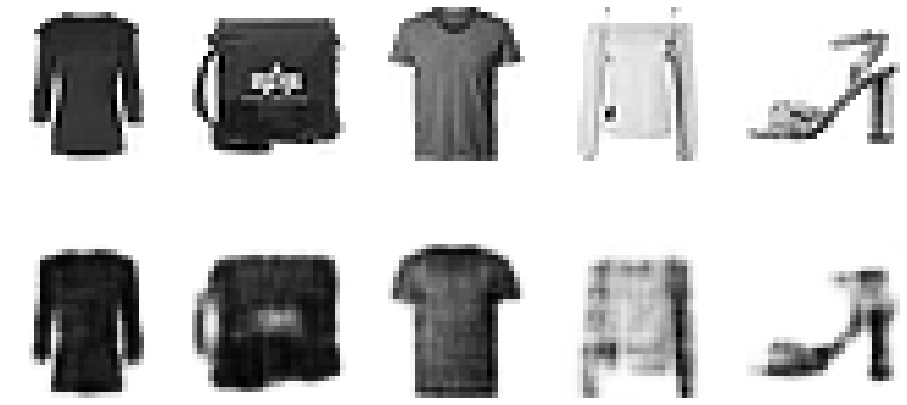

In [31]:
show_reconstructions(conv_ae)

## Recurrent Autoencoders

In [32]:

recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [33]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5055 - rounded_accuracy: 0.7681 - val_loss: 0.4378 - val_rounded_accuracy: 0.8087
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3930 - rounded_accuracy: 0.8494 - val_loss: 0.3714 - val_rounded_accuracy: 0.8682
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3634 - rounded_accuracy: 0.8711 - val_loss: 0.3635 - val_rounded_accuracy: 0.8714
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3515 - rounded_accuracy: 0.8796 - val_loss: 0.3475 - val_rounded_accuracy: 0.8857
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3421 - rounded_accuracy: 0.8856 - val_loss: 0.3405 - val_rounded_accuracy: 0.8868
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3350 - rounded_accuracy: 0.8907 - val_loss: 0.3326 - val_rounded_accuracy: 0.8922
Epoch 7/10
1719/1719 [============

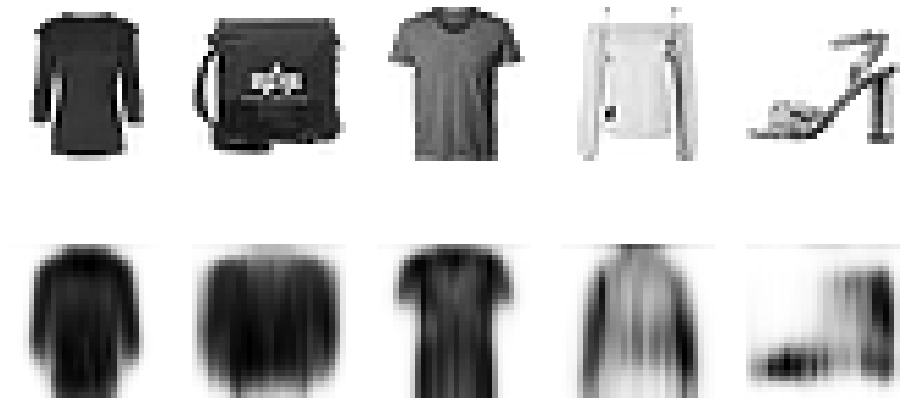

In [34]:
show_reconstructions(recurrent_ae)

## Stacked denoising Autoencoder

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3499 - rounded_accuracy: 0.8774 - val_loss: 0.3174 - val_rounded_accuracy: 0.9052
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3122 - rounded_accuracy: 0.9095 - val_loss: 0.3086 - val_rounded_accuracy: 0.9121
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3063 - rounded_accuracy: 0.9146 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3028 - rounded_accuracy: 0.9177 - val_loss: 0.3002 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2976 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9265
Epoch 7/10
1719/1719 [==================

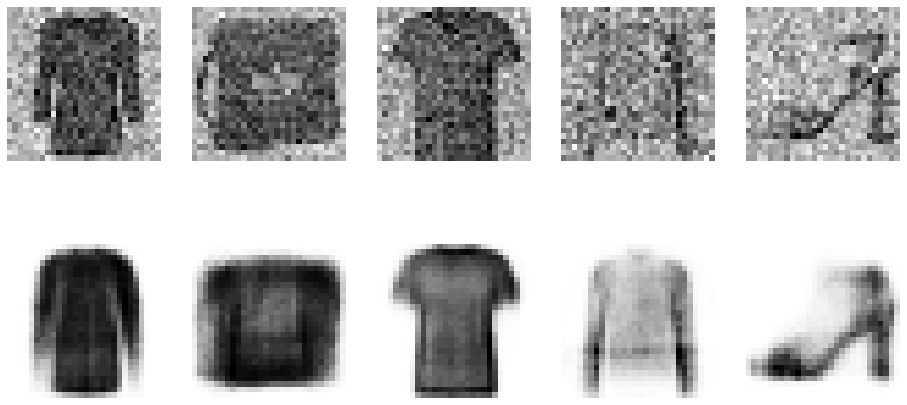

In [36]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

Using dropout:

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

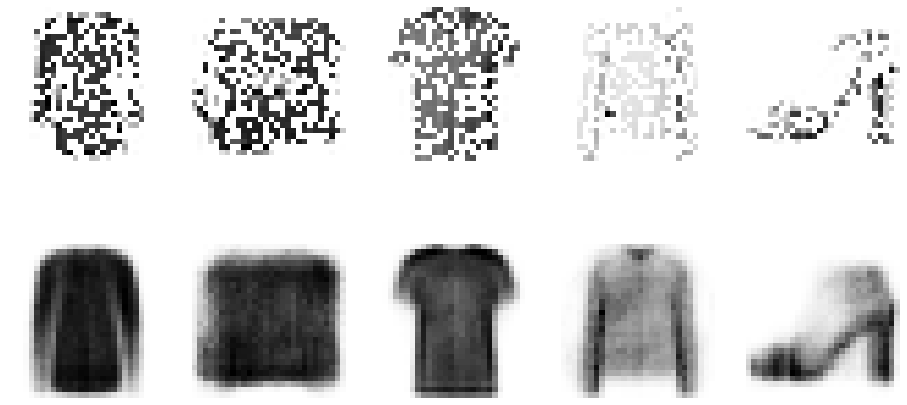

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

## Generative Adversarial Networks

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [40]:
gan.layers[0]

In [41]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [42]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [43]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()

In [44]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Epoch 1/1


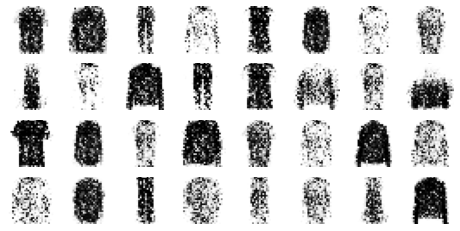

In [45]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

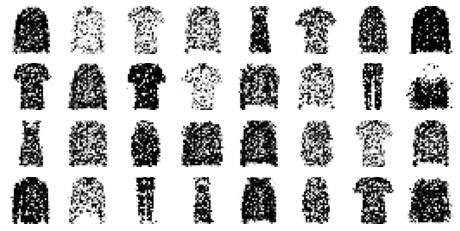

In [48]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Epoch 1/10


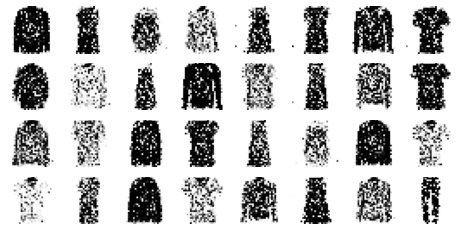

Epoch 2/10


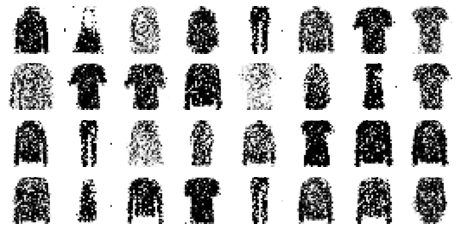

Epoch 3/10


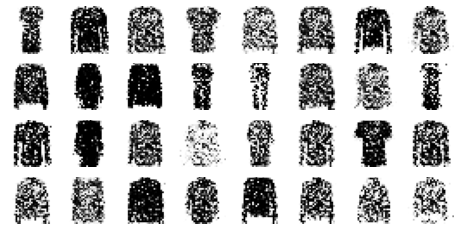

Epoch 4/10


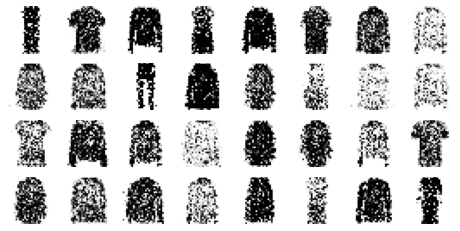

Epoch 5/10


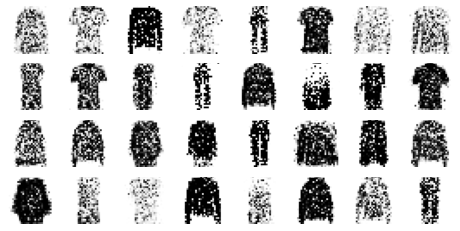

Epoch 6/10


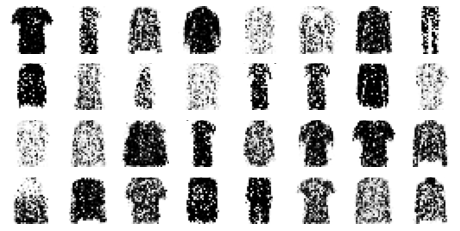

Epoch 7/10


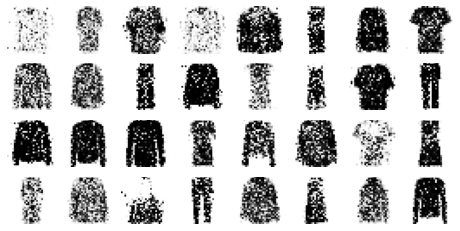

Epoch 8/10


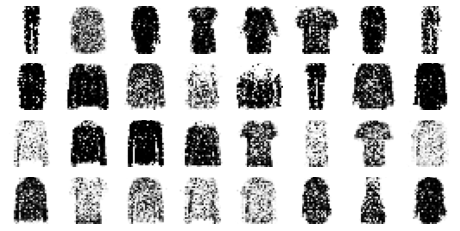

Epoch 9/10


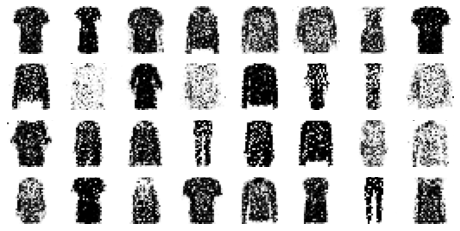

Epoch 10/10


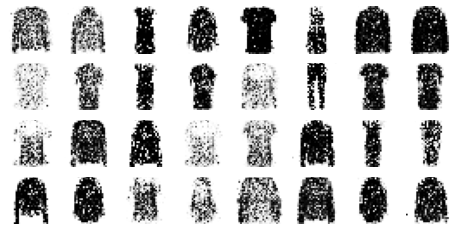

In [49]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = Sequential([
    Dense(7*7*128, input_shape=[codings_size]),
    Reshape([7,7,128]),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu'),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')
])

discriminator = Sequential([
    Conv2D(64, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(0.2), input_shape=[28,28,1]),
    Dropout(0.4),
    Conv2D(128, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(0.2)),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation='sigmoid')
])

gan = Sequential([generator, discriminator])

In [53]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [54]:
X_train.shape

(55000, 28, 28)

In [56]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [57]:
X_train_dcgan.shape

(55000, 28, 28, 1)

In [58]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10


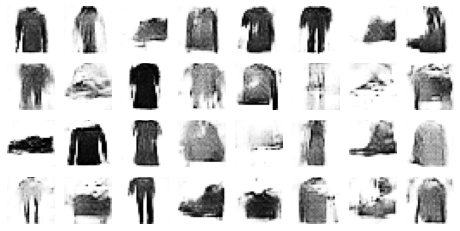

Epoch 2/10


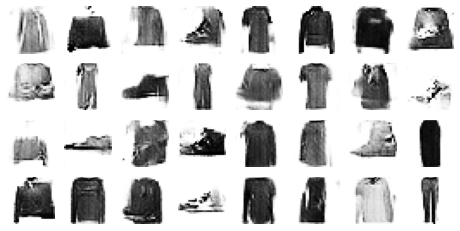

Epoch 3/10


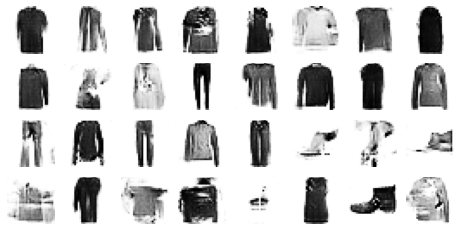

Epoch 4/10


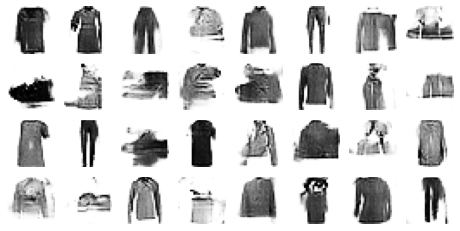

Epoch 5/10


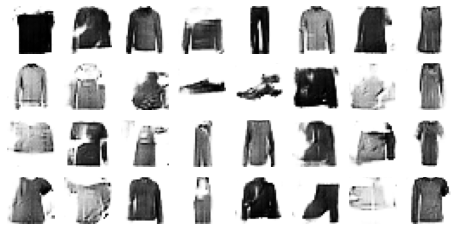

Epoch 6/10


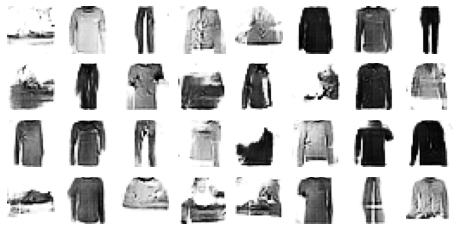

Epoch 7/10


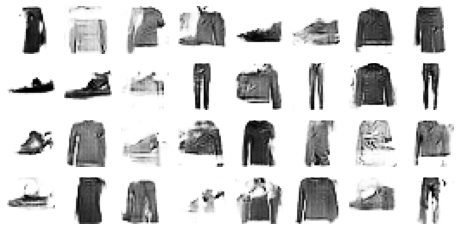

Epoch 8/10


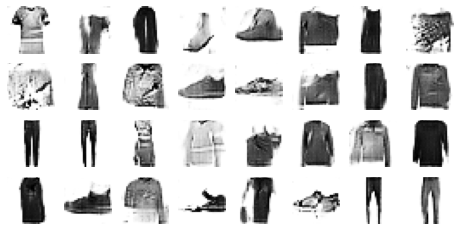

Epoch 9/10


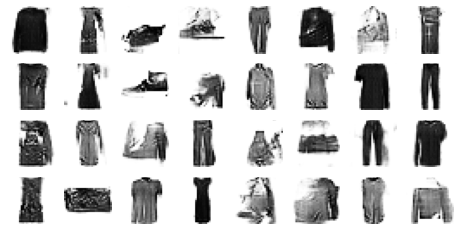

Epoch 10/10


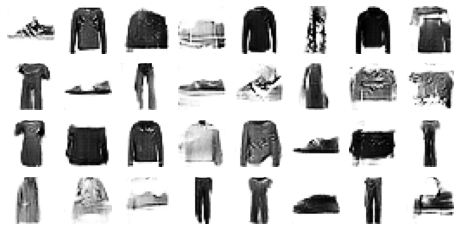

In [59]:
train_gan(gan, dataset, batch_size, codings_size)